In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Reading the data and preparing the file for input

In [2]:
df = pd.read_csv('./dataset_diabetes/diabetic_data.csv')

Counting the no of changes due to one or many of the 23 diabetes drugs given to the patient by change type -- 'Down', 'Steady' and 'Up'

In [3]:
drugs = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']



for x in df:
    count = 0
    for drug in drugs:
        count = count + (df[drug] =='Up')
    df['Up'] = count

for x in df:
    count = 0
    for drug in drugs:
        count = count + (df[drug] =='Steady')
    df['Steady'] = count

for x in df:
    count = 0
    for drug in drugs:
        count = count + (df[drug] =='Down')
    df['Down'] = count


Counting the total number of changes inn drug status and storing in a new column, 'drug_count'.  Assigining numerical values to the diabetes drug outcomes.

In [4]:
### Counting the total number of changes inn drug status and storing in a new column, 'drug_count'
df['drug_change'] = df['Up'] + df['Steady'] + df['Down']


### creating a map dictonary ###

drug_outcome_map = {'No':0, 'Up':1, 'Steady':2, 'Down':3}


for drug in drugs:
        df[drug] = df[drug].map(drug_outcome_map)

Diagnosis: Counting the number of disgnosis for each row and storing in a new column, 'diagnosis_count'. Retaining  the Top 10 diagnosis codes for each of the three diagnosis and assigning '0' value to all others. 

In [5]:
### Counting the number of disgnosis for each row and storing in a new column, 'diagnosis_count'
isY = lambda x:int(x!='?')
countDiagnosis = lambda row: isY(row['diag_1']) + isY(row['diag_2']) + isY(row['diag_3'])
df['diagnosis_count'] = df.apply(countDiagnosis,axis=1)


In [6]:
### Retianing the Top 10 diagnosis codes as shown below and assiging a ###
### code of 0 to others in the three diagnosis columns ####

df['diag_1'] =['0' if x not in ('428', '414' ,'786', '410', '486', '427', '491', '715', '682', '434') 
               else x for x in df['diag_1']]


df['diag_2'] =['0' if x not in ('276', '428','250','427','401','496','599','403','414','411') 
               else x for x in df['diag_2']]


df['diag_3'] =['0' if x not in ('250','401','276','428','427','414','496','403','585','272') 
               else x for x in df['diag_3']]

In [7]:
### Retianing the Top 5 codes as shown below and assiging a ###
### code of 0 to others in the three diagnosis columns ####

df['admission_type_id'] =['0' if x not in (1,2,3,5,6) else x for x in df['admission_type_id']]

df['discharge_disposition_id'] = ['0' if x not in (1,2,3,6,18) else x for x in df['discharge_disposition_id']]

df['admission_source_id'] =['0' if x not in (7,1,17,4,6) else x for x in df['admission_source_id']]

In [8]:
# df['drugs_max'] = df[features].max(axis=1)

# # drugs_to_drop = ['nateglinide', 'glyburide-metformin','acarbose', 'miglitol', 'tolbutamide', 'chlorpropamide', \        
#                  'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'acetohexamide', 'glipizide-metformin',\
#                  'glimepiride-pioglitazone', 'metformin-rosiglitazone','metformin-pioglitazone', 'metformin', \
#                  'repaglinide','glimepiride', 'glipizide', 'glyburide', 'pioglitazone','rosiglitazone', 'insulin']

# df = df.drop(columns=[, 'drug_others'])
# df['drug_others'] = df[drugs_to_drop].max(axis=1)
## Dropping select drug columns
df = df.drop(columns = drugs)

### Dropping Variables

In [9]:
### Dropping columns with large amount of missing data

cols_to_drop = ['encounter_id', 'patient_nbr','weight','payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult']

df = df.drop(columns = cols_to_drop)

In [10]:
### Dropping rows with missing gender and missing race ###

df = df[df['gender'] != 'Unknown/Invalid']

df = df[df['race'] != '?']

In [11]:
df =pd.get_dummies(df, columns= ['race', 'gender', 'age', 'admission_type_id',\
        'discharge_disposition_id', 'admission_source_id', 'diag_1','diag_2', \
        'diag_3','change', 'diabetesMed'], drop_first = True)

### Collapsing <30 days and >30 days readmits to one readmits and turning the problem to binary classification.  

In [12]:
### creating a map dictonary ###

readmit_map = {'<30':1, '>30':1, 'NO':0}


df['readmitted'] = df['readmitted'].map(readmit_map)

In [13]:
# Import libraries needed for models
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [14]:
X = df.drop(columns=['readmitted'])
y = df['readmitted']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.25,
    random_state = 42
)

sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

#### Logistic Regression

In [15]:
### Instantiate & Fit Multinomial Logistic Regression ###

lr = LogisticRegression( max_iter=10000, penalty = 'elasticnet', l1_ratio = 0.25, solver='saga').fit(Z_train, y_train)

In [16]:
#Output predictions to output df
output = pd.DataFrame(y_test)

output['lr_predicts' ] = lr.predict(Z_test)


In [17]:
pd.crosstab(output['readmitted'], output['lr_predicts'])

lr_predicts,0,1
readmitted,,
0,10268,3001
1,6297,5307


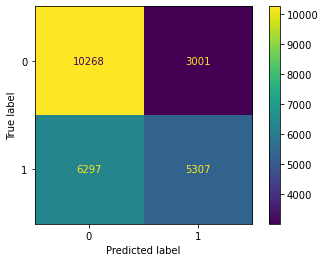

In [18]:
plot_confusion_matrix(lr,Z_test, y_test, values_format='d');

#### Decision Tree

In [19]:
### Decision Tree Classifier ###

## Import
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

In [20]:
### Instantiate and Fit
random =30
dt = DecisionTreeClassifier(random_state = random, max_depth = 5).fit(Z_train, y_train)

In [21]:
### Output predictions to output df
output['dt_predicts' ] = dt.predict(Z_test)

In [22]:
### Cross-tab Confusion Matrix
pd.crosstab(output['readmitted'], output['dt_predicts'])

dt_predicts,0,1
readmitted,,
0,9385,3884
1,5547,6057


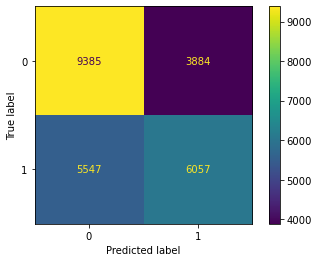

In [23]:
### Plot Confusion Matrix
plot_confusion_matrix(dt,Z_test, y_test, values_format='d');

#### KNN Classifier

In [24]:
### KNN Classifier ###

## Import ##
from sklearn.neighbors import KNeighborsClassifier

In [25]:
#KNN Classifier

## Instantiate & Fit KNN Classifier 
knn = KNeighborsClassifier().fit(Z_train, y_train)


In [26]:
### Output predictions to output df
output['knn_predicts' ] = knn.predict(Z_test)

In [27]:
pd.crosstab(output['readmitted'], output['knn_predicts'])

knn_predicts,0,1
readmitted,,
0,8551,4718
1,6034,5570


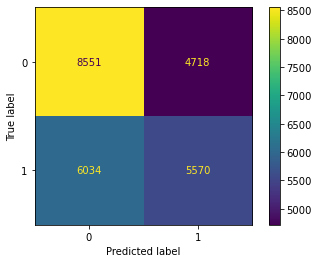

In [28]:
plot_confusion_matrix(knn,Z_test, y_test, values_format='d');

#### Bagging

In [29]:
### Bagging and Random Forests ##

## Import ##
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier


In [30]:
### Instantiate and Fit Bagging Classifier ###
bag = BaggingClassifier(random_state = random).fit(Z_train, y_train)

In [31]:
### Output predictions to output df
output['bag_predicts' ] = bag.predict(Z_test)

In [32]:
### Cross-tab Confusion Matrix
pd.crosstab(output['readmitted'], output['bag_predicts'])

bag_predicts,0,1
readmitted,,
0,9531,3738
1,6320,5284


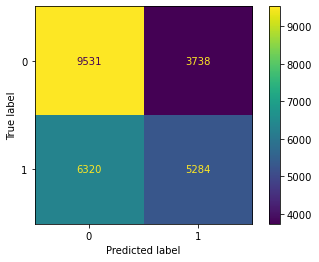

In [33]:
### Plot Confusion Matrix
plot_confusion_matrix(bag,Z_test, y_test, values_format='d');

#### Random Forest

In [34]:
### Random Forest ###

### Instantiate and Fit Random Forest Classifier ###
rf = RandomForestClassifier(n_estimators=1000).fit(Z_train, y_train)

In [35]:
### Output predictions to output df
output['rf_predicts' ] = rf.predict(Z_test)

In [36]:
### Cross-tab Confusion Matrix
pd.crosstab(output['readmitted'], output['rf_predicts'])

rf_predicts,0,1
readmitted,,
0,9548,3721
1,5450,6154


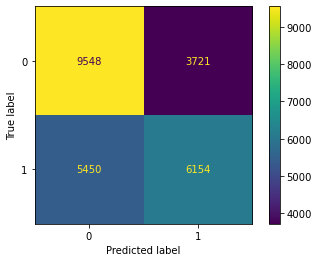

In [37]:
### Plot Confusion Matrix
plot_confusion_matrix(rf,Z_test, y_test, values_format='d');

#### Linear SVM Classifier

In [38]:
### SVM Linear ###

## Import ##
from sklearn.svm import LinearSVC

In [39]:
### Instantiate and Fit SVM Linear Classifier ###
svc = LinearSVC(max_iter=20000).fit(Z_train, y_train)

C:\Users\Rhino\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [40]:
### Output predictions to output df
output['svc_predicts' ] = svc.predict(Z_test)


In [41]:
### Cross-tab Confusion Matrix
pd.crosstab(output['readmitted'], output['svc_predicts'])

svc_predicts,0,1
readmitted,,
0,10354,2915
1,6396,5208


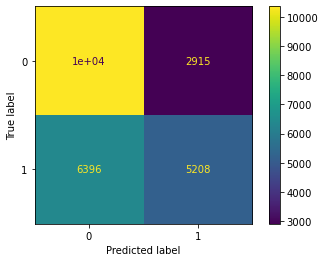

In [42]:
### Plot Confusion Matrix
plot_confusion_matrix(svc,Z_test, y_test);

#### Stochastic Gradient Descent (SGD)

In [43]:
from sklearn.linear_model import SGDClassifier

In [44]:
### Instantiate and Fit SVM Linear Classifier ###
sgdc = SGDClassifier(max_iter=1000, tol=0.01).fit(Z_train, y_train)

In [45]:
### Output predictions to output df
output['sgdc_predicts' ] = sgdc.predict(Z_test)
### Cross-tab Confusion Matrix
pd.crosstab(output['readmitted'], output['sgdc_predicts'])

sgdc_predicts,0,1
readmitted,,
0,9656,3613
1,6276,5328


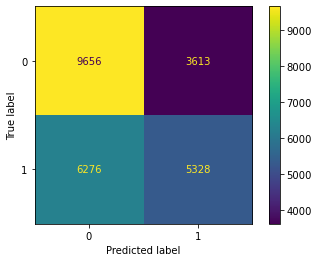

In [46]:
### Plot Confusion Matrix
plot_confusion_matrix(sgdc,Z_test, y_test);

In [47]:
print(f"Logisitic Regression: {lr.score(Z_test, y_test)}")
print(f"Decision Tree: {dt.score(Z_test, y_test)}")
print(f"KNN Classifier: {knn.score(Z_test, y_test)}")
print(f"Random Forest: {rf.score(Z_test, y_test)}")
print(f"Bagging: {bag.score(Z_test, y_test)}")
print(f"Support Vector Classifier: {svc.score(Z_test, y_test)}")
print(f"Stochastic Gradient Descent : {sgdc.score(Z_test, y_test)}")   

Logisitic Regression: 0.626180999477345
Decision Tree: 0.6208338358863024
KNN Classifier: 0.5677240381136172
Random Forest: 0.6312869376432276
Bagging: 0.5956257789571021
Support Vector Classifier: 0.6256583443894986
Stochastic Gradient Descent : 0.6024202950991034


#### Exploring Pipelines & PCA
Checking if a reduced data set is effective for Logistic Regression

In [48]:
### Source: https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html
# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])


# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [5, 15, 30, 45, 64, 74],
    'logistic__C': np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(Z_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)



Best parameter (CV score=0.630):
{'logistic__C': 21.54434690031882, 'pca__n_components': 74}


#### Exporting Probability of Admits for each of the Classifiers & creating deciles based on the probabilities

_Excludes Linear SVM_

In [49]:
### Pushing Logisitic Regression probabilities to output df

output['lr_prob_0'] = lr.predict_proba(Z_test)[:,0]
output['lr_prob_1'] = lr.predict_proba(Z_test)[:,1]

## Sorting by prob_1

output.sort_values(by = 'lr_prob_1', ascending = False, inplace=True)

# adding Decile_rank column to the DataFrame 

output['lr_decile_rank'] = pd.qcut(output['lr_prob_1'], 10, labels = False)

In [50]:
###Exporting Logisitic Regression probabilities Only
output.to_csv('./output_trunc_lr.csv', index=False)

In [51]:
### Pushing Randon Forest probabilities to output df

output['rf_prob_0'] = rf.predict_proba(Z_test)[:,0]
output['rf_prob_1'] = rf.predict_proba(Z_test)[:,1]

## Sorting by prob_1

output.sort_values(by = 'rf_prob_1', ascending = False, inplace=True)

# adding Decile_rank column to the DataFrame 

output['rf_decile_rank'] = pd.qcut(output['rf_prob_1'], 10, duplicates ='raise',labels = False)

In [52]:
### Pushing Bagging probabilities to output df

output['bag_prob_0'] = bag.predict_proba(Z_test)[:,0]
output['bag_prob_1'] = bag.predict_proba(Z_test)[:,1]

## Sorting by prob_1

# output.sort_values(by = 'bag_prob_1', ascending = False, inplace=True)

# adding Decile_rank column to the DataFrame 

output['bag_decile_rank'] = pd.qcut(output['bag_prob_1'].rank(method='first'), 10, labels = False)


In [53]:
### Pushing Decision Tree probabilities to output df

output['dt_prob_0'] = dt.predict_proba(Z_test)[:,0]
output['dt_prob_1'] = dt.predict_proba(Z_test)[:,1]


# adding Decile_rank column to the DataFrame 

output['dt_decile_rank'] = pd.qcut(output['dt_prob_1'].rank(method='first'), 10, labels = False)

In [54]:
### Pushing Decision Tree probabilities to output df

output['knn_prob_0'] = knn.predict_proba(Z_test)[:,0]
output['knn_prob_1'] = knn.predict_proba(Z_test)[:,1]


# adding Decile_rank column to the DataFrame 

output['knn_decile_rank'] = pd.qcut(output['knn_prob_1'].rank(method='first'), 10, labels = False)

In [55]:
###Exporting all ranks and probabilities)
output.to_csv('./output_trunc.csv', index=False)

In [56]:
Z_train.shape, y_train.shape, Z_test.shape, y_test.shape

((74619, 74), (74619,), (24873, 74), (24873,))

### Using Neural Network

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

%matplotlib inline

In [58]:
# from sklearn.preprocessing import LabelEncoder
# from keras.utils import np_utils

# # first we have to encode class values as integers
# encoder = LabelEncoder()
# encoder.fit(y_train)
# y_train_encoded = encoder.transform(y_train)
# Y_train = np_utils.to_categorical(y_train_encoded)
# y_test_encoded = encoder.transform(y_test)
# Y_test = np_utils.to_categorical(y_test_encoded)

In [59]:
model =Sequential()
model.add(Dense(128,  ## No of neurons in the first layer Rule of thumbs base 2 # > no of features
          input_shape = (74, ), ##shape of one sample of the training data
          activation= 'relu')) ##rectified linear unit -- very popular & common

model.add(Dense(64, activation = 'relu'))

model.add(Dense(16, activation = 'relu'))



model.add(Dense(1, activation = 'sigmoid'))
          
# Compile it

# What are the two primary components of compiling the NN? 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [60]:
model_dropout =Sequential()
model_dropout.add(Dense(128,  ## No of neurons in the first layer Rule of thumbs base 2 # > no of features
          input_shape = (74, ), ##shape of one sample of the training data
          activation= 'relu')) ##rectified linear unit -- very popular & common
model_dropout.add(Dropout(0.2))  ##Add here

model_dropout.add(Dense(64, activation = 'relu'))
model_dropout.add(Dropout(0.2))  ##Add droupout

model_dropout.add(Dense(16, activation = 'relu'))
model_dropout.add(Dropout(0.2))  ##Add droupout


model_dropout.add(Dense(1, activation = 'sigmoid'))
          
# Compile it

# What are the two primary components of compiling the NN? 
model_dropout.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])




In [61]:
# Fit the model
# What are all the possible components here? What are the areas we explored on Thursday?

history= model.fit(Z_train, y_train, validation_data=(Z_test, y_test), epochs=100, batch_size=512, verbose=1)


Epoch 1/100
146/146 [==============================] - 1s 4ms/step - loss: 0.6531 - accuracy: 0.6133 - val_loss: 0.6448 - val_accuracy: 0.6278
Epoch 2/100
146/146 [==============================] - 0s 2ms/step - loss: 0.6351 - accuracy: 0.6363 - val_loss: 0.6407 - val_accuracy: 0.6321
Epoch 3/100
146/146 [==============================] - 0s 2ms/step - loss: 0.6286 - accuracy: 0.6444 - val_loss: 0.6410 - val_accuracy: 0.6313
Epoch 4/100
146/146 [==============================] - 0s 2ms/step - loss: 0.6231 - accuracy: 0.6508 - val_loss: 0.6400 - val_accuracy: 0.6302
Epoch 5/100
146/146 [==============================] - 0s 2ms/step - loss: 0.6188 - accuracy: 0.6541 - val_loss: 0.6421 - val_accuracy: 0.6312
Epoch 6/100
146/146 [==============================] - 0s 2ms/step - loss: 0.6144 - accuracy: 0.6585 - val_loss: 0.6426 - val_accuracy: 0.6307
Epoch 7/100
146/146 [==============================] - 0s 2ms/step - loss: 0.6098 - accuracy: 0.6651 - val_loss: 0.6447 - val_accuracy: 0.6282

Epoch 58/100
146/146 [==============================] - 0s 2ms/step - loss: 0.4544 - accuracy: 0.7789 - val_loss: 0.8695 - val_accuracy: 0.5846
Epoch 59/100
146/146 [==============================] - 0s 2ms/step - loss: 0.4533 - accuracy: 0.7798 - val_loss: 0.8893 - val_accuracy: 0.5888
Epoch 60/100
146/146 [==============================] - 0s 2ms/step - loss: 0.4509 - accuracy: 0.7825 - val_loss: 0.8823 - val_accuracy: 0.5832
Epoch 61/100
146/146 [==============================] - 0s 2ms/step - loss: 0.4496 - accuracy: 0.7830 - val_loss: 0.8886 - val_accuracy: 0.5823
Epoch 62/100
146/146 [==============================] - 0s 2ms/step - loss: 0.4479 - accuracy: 0.7835 - val_loss: 0.8907 - val_accuracy: 0.5847
Epoch 63/100
146/146 [==============================] - 0s 2ms/step - loss: 0.4461 - accuracy: 0.7828 - val_loss: 0.8944 - val_accuracy: 0.5817
Epoch 64/100
146/146 [==============================] - 0s 2ms/step - loss: 0.4457 - accuracy: 0.7852 - val_loss: 0.9085 - val_accuracy:

In [62]:
# Fit the model
# What are all the possible components here? What are the areas we explored on Thursday?

history_dropout= model_dropout.fit(Z_train, y_train, validation_data=(Z_test, y_test), epochs=100, batch_size=512, verbose=1)


Epoch 1/100
146/146 [==============================] - 1s 4ms/step - loss: 0.6795 - accuracy: 0.5701 - val_loss: 0.6540 - val_accuracy: 0.6154
Epoch 2/100
146/146 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6149 - val_loss: 0.6454 - val_accuracy: 0.6277
Epoch 3/100
146/146 [==============================] - 0s 3ms/step - loss: 0.6467 - accuracy: 0.6234 - val_loss: 0.6428 - val_accuracy: 0.6278
Epoch 4/100
146/146 [==============================] - 1s 4ms/step - loss: 0.6431 - accuracy: 0.6294 - val_loss: 0.6405 - val_accuracy: 0.6342
Epoch 5/100
146/146 [==============================] - 1s 3ms/step - loss: 0.6396 - accuracy: 0.6323 - val_loss: 0.6407 - val_accuracy: 0.6329
Epoch 6/100
146/146 [==============================] - 1s 4ms/step - loss: 0.6382 - accuracy: 0.6357 - val_loss: 0.6377 - val_accuracy: 0.6353
Epoch 7/100
146/146 [==============================] - 1s 3ms/step - loss: 0.6371 - accuracy: 0.6348 - val_loss: 0.6389 - val_accuracy: 0.6348

Epoch 58/100
146/146 [==============================] - 1s 4ms/step - loss: 0.5964 - accuracy: 0.6740 - val_loss: 0.6464 - val_accuracy: 0.6249
Epoch 59/100
146/146 [==============================] - 1s 3ms/step - loss: 0.5957 - accuracy: 0.6749 - val_loss: 0.6462 - val_accuracy: 0.6256
Epoch 60/100
146/146 [==============================] - 0s 3ms/step - loss: 0.5975 - accuracy: 0.6752 - val_loss: 0.6471 - val_accuracy: 0.6233
Epoch 61/100
146/146 [==============================] - 1s 3ms/step - loss: 0.5955 - accuracy: 0.6759 - val_loss: 0.6482 - val_accuracy: 0.6209
Epoch 62/100
146/146 [==============================] - 1s 3ms/step - loss: 0.5955 - accuracy: 0.6766 - val_loss: 0.6467 - val_accuracy: 0.6253
Epoch 63/100
146/146 [==============================] - 1s 3ms/step - loss: 0.5954 - accuracy: 0.6755 - val_loss: 0.6474 - val_accuracy: 0.6256
Epoch 64/100
146/146 [==============================] - 0s 3ms/step - loss: 0.5931 - accuracy: 0.6785 - val_loss: 0.6483 - val_accuracy:

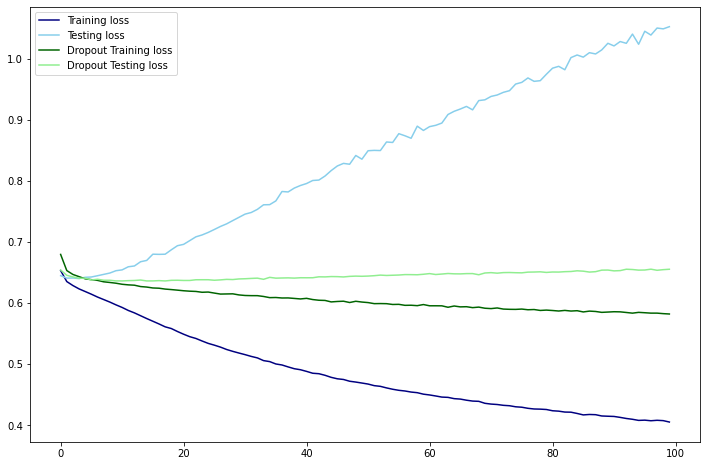

In [63]:
# Visualize loss
train_loss = history.history['loss']
test_loss = history.history['val_loss']


train_loss_dropout = history_dropout.history['loss']
test_loss_dropout = history_dropout.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.plot(train_loss_dropout, label='Dropout Training loss', color='darkgreen')
plt.plot(test_loss_dropout, label='Dropout Testing loss', color='lightgreen')
plt.legend();